# Study 3: Medical experiment

## Libraries

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.transforms as mtrans
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch
#plt.rcParams['figure.figsize'] = [12, 8]
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Print library versions
print("numpy version: " + str(np.__version__))
print("pandas version: " + str(pd.__version__))
print("scipy version: " + str(scipy.__version__))
print("statsmodels version: " + str(sm.__version__))
print("matplotlib version: " + str(matplotlib.__version__))
print("seaborn version: " + str(sns.__version__))

numpy version: 1.24.3
pandas version: 1.5.3
scipy version: 1.11.1
statsmodels version: 0.14.0
matplotlib version: 3.7.1
seaborn version: 0.12.2


## Study data

In [3]:
# Import study data (excluding dropouts)
data = pd.read_csv("data_study_03.csv")

In [4]:
# Print columns names
print(data.columns)

Index(['IPAddress', 'it_skills', 'tenure', 'Specialization',
       'LocationLongitude', 'LocationLatitude', 'att_check', 'treatment',
       'order', 'completed_images', 'balanced_accuracy',
       'defect_detection_rate', 'specificity', 'precision',
       'adherence_accurate_prediction', 'overrule_wrong_prediction',
       'median_decision_speed', 'only_one_answer'],
      dtype='object')


In [5]:
# Rename treatment arms to "a" and "b"
data["treatment"][data["treatment"]=="human_with_black-box_AI"] = "a"
data["treatment"][data["treatment"]=="human_with_explainable_AI"] = "b"

In [6]:
print("Number of participants:", len(data))

Number of participants: 118


In [7]:
# Remove patients that timed out
data = data[data["completed_images"] == 50]

In [8]:
# Print number of participants who completed the study on time
print("Number of participants who completed the study within 35 minutes: " + str(data.shape[0]))

Number of participants who completed the study within 35 minutes: 116


In [9]:
# Remove participants who assigned only one label to all images
data = data[data["only_one_answer"]==0]

In [10]:
print("Number of participants with non-unique assigned labels:", len(data))

Number of participants with non-unique assigned labels: 115


In [11]:
# Remove participants whose performance was more than three standard deviations worse than the mean of their respective treatment arm
cutoff_a = data["balanced_accuracy"][data["treatment"]=="a"].mean() - 3*data["balanced_accuracy"][data["treatment"] == "a"].std()
cutoff_b = data["balanced_accuracy"][data["treatment"]=="b"].mean() - 3*data["balanced_accuracy"][data["treatment"] == "b"].std()
cutoff_c = data["balanced_accuracy"][data["treatment"]=="c"].mean() - 3*data["balanced_accuracy"][data["treatment"] == "c"].std()
data = data[~((data["treatment"]=="a") & (data["balanced_accuracy"]<cutoff_a))]
data = data[~((data["treatment"]=="b") & (data["balanced_accuracy"]<cutoff_b))]
data = data[~((data["treatment"]=="c") & (data["balanced_accuracy"]<cutoff_c))]

In [12]:
# Print number of participants in the final sample
print("Number of participants in the final sample: " + str(data.shape[0]))

Number of participants in the final sample: 113


In [13]:
# Print number of participants per treatment arm
print("Number of participants with black-box AI treatment: " + str(data[data["treatment"]=="a"].shape[0]))
print("Number of participants with explainable AI treatment: " + str(data[data["treatment"]=="b"].shape[0]))

Number of participants with black-box AI treatment: 61
Number of participants with explainable AI treatment: 52


## Study results 

### Boxplots for balanced accuracy

In [14]:
ai_bacc = 0.8222591362126246
ai_ddr = 0.7142857142857143

In [15]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]
plt.rcParams['font.size'] = 22
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['mathtext.fontset'] = 'stix'
# plt.rcParams['mathtext.rm'] = 'Bitstream Times New Roman'
# plt.rcParams['mathtext.it'] = 'Bitstream Times New Roman:italic'
# plt.rcParams['mathtext.bf'] = 'Bitstream Times New Roman:bold'

In [16]:
from curlyBrace import curlyBrace

In [17]:
font = {#'family': 'serif',
        #'fontname': 'Times New Roman',
        #'style': 'italic',
        'size': 20,
        }

In [18]:
# Define colors
red = (0.59,0.0,0.09)
blue = (0.09,0.43,0.61)
orange = (0.8,0.33,0)

t-stat: -2.709, P-val: 0.004


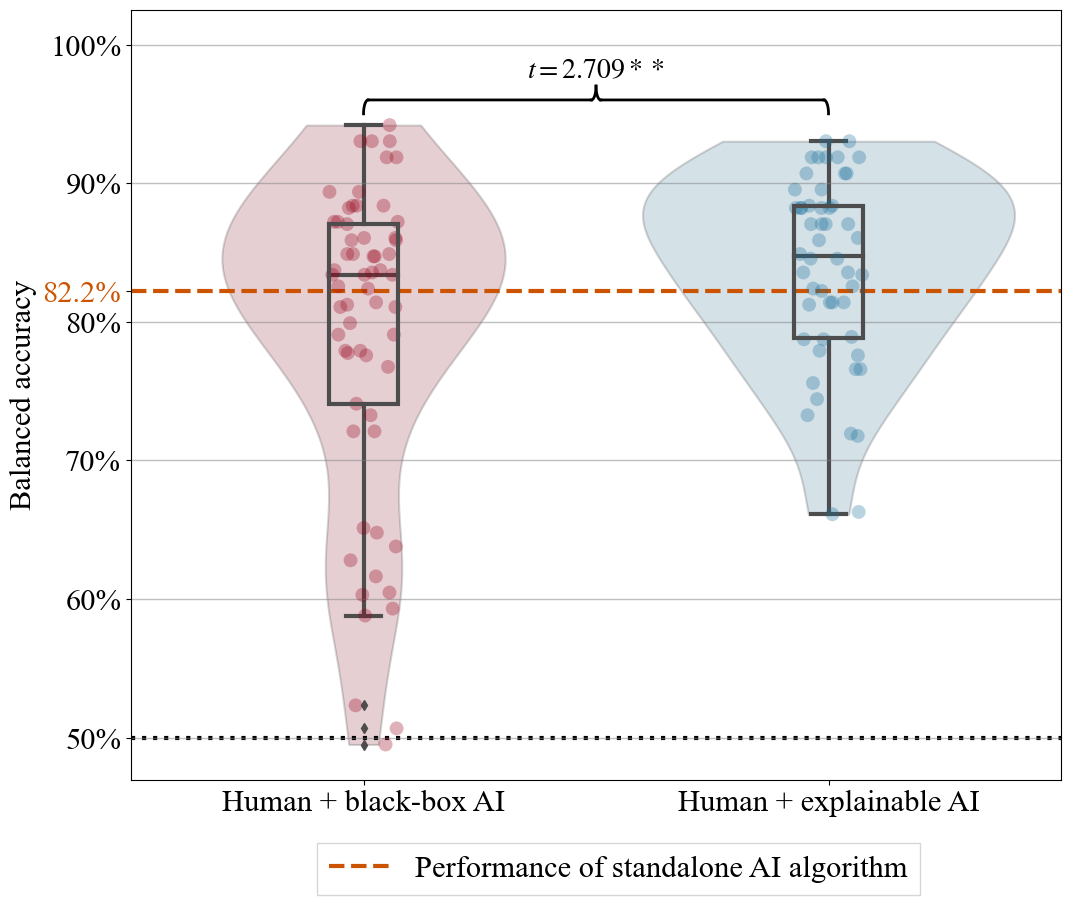

In [19]:
# Plot balanced accuracy for all participants
# Calculate t-statistic and p-value
t_stat = stats.ttest_ind(data["balanced_accuracy"][data["treatment"]=="a"], data["balanced_accuracy"][data["treatment"]=="b"], equal_var = False)[0]
p_val = stats.ttest_ind(data["balanced_accuracy"][data["treatment"]=="a"], data["balanced_accuracy"][data["treatment"]=="b"], equal_var = False)[1]/2
if p_val < 0.001:
    ast = '***'
elif p_val < 0.01:
    ast = '**'
elif p_val < 0.05:
    ast = '*'
else:
    ast = ' '
print("t-stat: " + str(round(t_stat,3))+ ", P-val: " + str(round(p_val,4)))
fig = plt.figure()
ax = sns.violinplot(x="treatment", y="balanced_accuracy", data=data, inner=None, palette=[red, blue], alpha=0.4, cut=0, order=["a", "b"])
for art in ax.collections:
    art.set_alpha(0.2)
ax1 = sns.boxplot(x="treatment", y="balanced_accuracy", data=data, orient="v", width=0.15, color="grey", linewidth=3, boxprops={'facecolor':'none', "zorder":10}, order=["a", "b"])
ax1 = sns.stripplot(x="treatment", y="balanced_accuracy", data=data, palette=[red, blue], size=10, jitter=0.075, order=["a", "b"], alpha=0.3)
#plt.scatter(0, data[data['treatment'] == 'a']['balanced_accuracy'].mean(), marker='s', color='black', s=50, alpha=0.6)
#plt.scatter(1, data[data['treatment'] == 'b']['balanced_accuracy'].mean(), marker='s', color='black', s=50, alpha=0.6, label='Mean')
plt.hlines(ai_bacc, -0.5, 1.5, linestyles='--', color=orange, linewidth=3, alpha=1, label='Performance of standalone AI algorithm')
plt.hlines(0.5, -0.5, 1.5, linestyles='dotted', color='black', linewidth=3, alpha=1)
for i in np.arange(0.5, 1.09, 0.1):
    plt.hlines(i, -0.5, 1.5, color='grey', linewidth=1, alpha=0.5)
plt.xticks([0, 1], ["Human + black-box AI", "Human + explainable AI"])
plt.yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1, ai_bacc], labels=['50%', '60%', '70%', '80%', '90%', '100%', f'{np.round(ai_bacc*100, 1)}%'])
plt.xlabel("")
plt.xlim(-0.5, 1.5)
plt.ylabel("Balanced accuracy")
plt.legend(loc=(0.2, -0.15), fancybox=False)
ax.get_yticklabels()[-1].set_color((0.8,0.33,0))
curlyBrace(fig, ax, [0, 0.95], [1, 0.95], 0.01, bool_auto=False, str_text=f'$t={np.round(np.abs(t_stat),3)}{ast}$', color='black', lw=2, int_line_num=1, fontdict=font)
plt.savefig('results_balanced_accuracy_study3.pdf', bbox_inches='tight')

t-stat: -2.709, P-val: 0.004
t-stat: 0.006, P-val: 0.4976


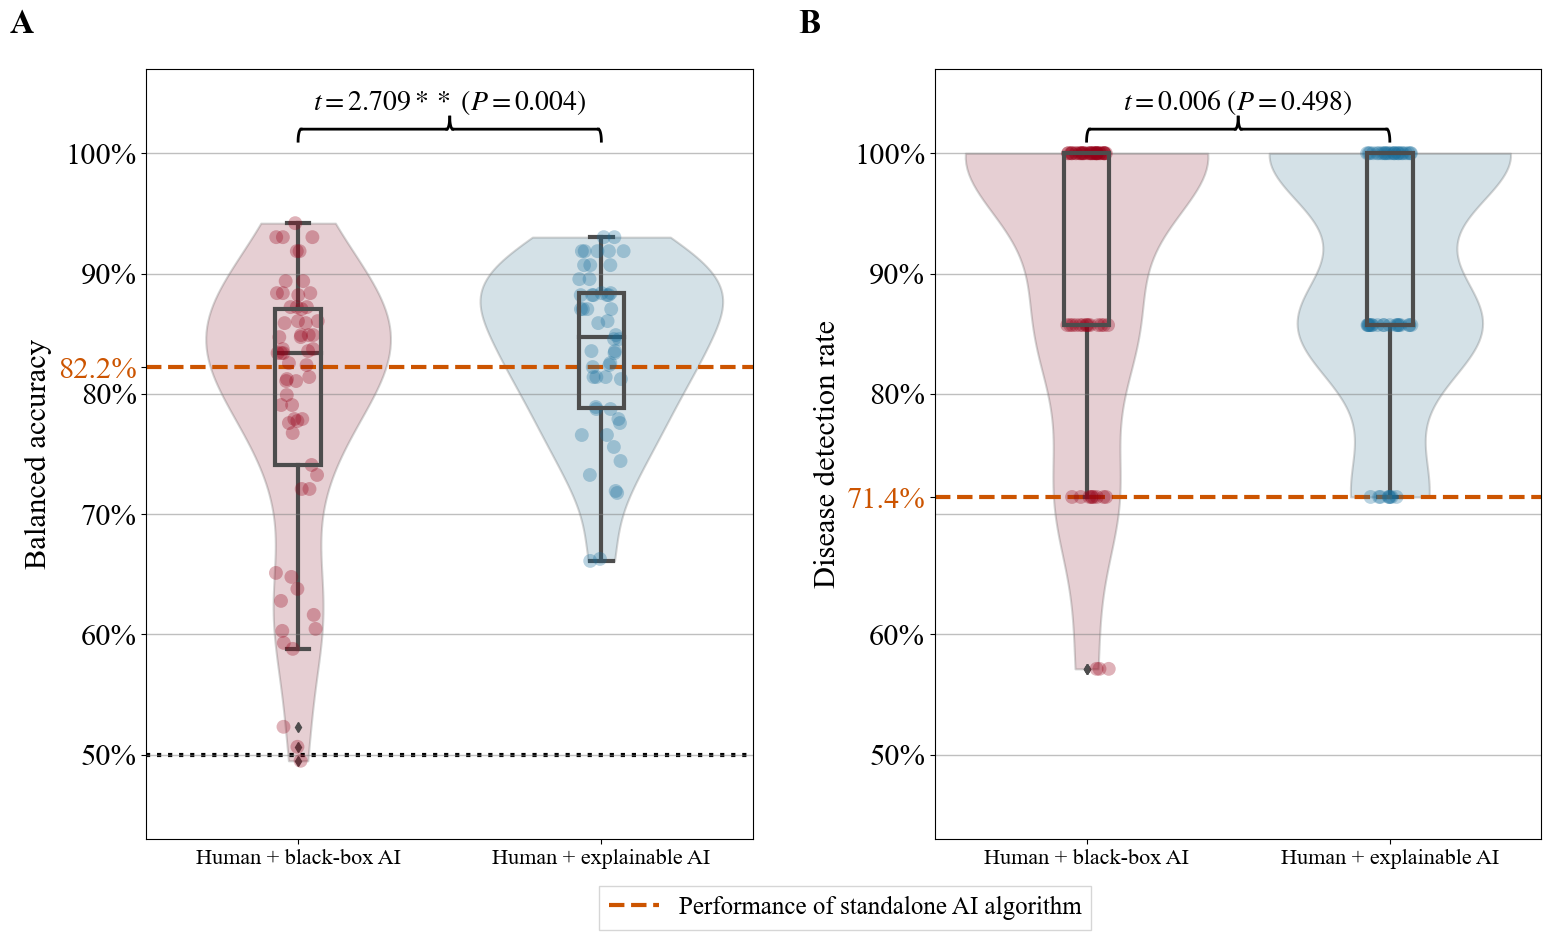

In [20]:
# Plot balanced accuracy and disease detection rate for all participants
# Calculate t-statistic and p-value
plt.figure(figsize=(18, 10))
plt.subplots_adjust(wspace=0.3)
for metric in ['balanced_accuracy', 'defect_detection_rate']:
    if metric == 'balanced_accuracy':
        ai_metric = ai_bacc
        plot_id = 1
        label = 'Balanced accuracy'
        legend = 'Performance of standalone AI algorithm'
    elif metric == 'defect_detection_rate':
        ai_metric = ai_ddr
        plot_id = 2
        label = 'Disease detection rate'
        legend = None
    else:
        raise ValueError('Unknown metric', metric)
    plt.subplot(1, 2, plot_id)
    t_stat = stats.ttest_ind(data[metric][data["treatment"]=="a"], data[metric][data["treatment"]=="b"], equal_var = False)[0]
    p_val = stats.ttest_ind(data[metric][data["treatment"]=="a"], data[metric][data["treatment"]=="b"], equal_var = False)[1]/2
    if p_val < 0.001:
        ast = '***'
    elif p_val < 0.01:
        ast = '**'
    elif p_val < 0.05:
        ast = '*'
    else:
        ast = ' '
    print("t-stat: " + str(round(t_stat,3))+ ", P-val: " + str(round(p_val,4)))
    #fig = plt.figure()
    ax = sns.violinplot(x="treatment", y=metric, data=data, inner=None, palette=[red, blue], alpha=0.4, cut=0, order=["a", "b"])
    for art in ax.collections:
        art.set_alpha(0.2)
    ax1 = sns.boxplot(x="treatment", y=metric, data=data, orient="v", width=0.15, color="grey", linewidth=3, boxprops={'facecolor':'none', "zorder":10}, order=["a", "b"])
    ax1 = sns.stripplot(x="treatment", y=metric, data=data, palette=[red, blue], size=10, jitter=0.075, order=["a", "b"], alpha=0.3)
    #plt.scatter(0, data[data['treatment'] == 'a']['balanced_accuracy'].mean(), marker='s', color='black', s=50, alpha=0.6)
    #plt.scatter(1, data[data['treatment'] == 'b']['balanced_accuracy'].mean(), marker='s', color='black', s=50, alpha=0.6, label='Mean')
    plt.hlines(ai_metric, -0.5, 1.5, linestyles='--', color=orange, linewidth=3, alpha=1, label=legend)
    if metric == 'balanced_accuracy':
        plt.hlines(0.5, -0.5, 1.5, linestyles='dotted', color='black', linewidth=3, alpha=1)
    for i in np.arange(0.5, 1.09, 0.1):
        plt.hlines(i, -0.5, 1.5, color='grey', linewidth=1, alpha=0.5)
    plt.xticks([0, 1], ["Human + black-box AI", "Human + explainable AI"], fontsize=16)
    if metric == 'balanced_accuracy':
        plt.yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1, ai_metric], labels=['50%', '60%', '70%', '80%', '90%', '100%', f'{np.round(ai_metric*100, 1)}%'])
    else:
        plt.yticks([0.5, 0.6, 0.8, 0.9, 1, ai_metric], labels=['50%', '60%', '80%', '90%', '100%', f'{np.round(ai_metric*100, 1)}%'])
    plt.xlabel(None)
    plt.ylabel(label)
    plt.xlim(-0.5, 1.5)
    plt.ylim(0.43, 1.07)
    #plt.title(label)
    ax.get_yticklabels()[-1].set_color((0.8,0.33,0))
    brace_y_offset = data[metric].max() + 0.01
    curlyBrace(fig, ax, [0, 1.01], [1, 1.01], 0.01, bool_auto=False, str_text=f'$t={np.round(np.abs(t_stat),3)}{ast} \, \, (P={np.round(p_val, 3)})$', color='black', lw=2, int_line_num=1, fontdict=font)
    #if plot_id == 1:
    #    plt.legend(loc=(0.4, -0.15))
    if metric == 'balanced_accuracy':
        plt.text(-0.95, 1.1, 'A', weight='bold', fontsize=24)
    else:
        plt.text(-0.95, 1.1, 'B', weight='bold', fontsize=24)
plt.figlegend(loc=(0.386, 0.015), fancybox=False, fontsize=18)
#plt.tight_layout()
plt.savefig('results_combined_study3.pdf', bbox_inches='tight')

### Statistical test for balanced accuracy

In [21]:
# Print mean balanced accuracy for treatment arms
print(round(data["balanced_accuracy"][data["treatment"]=="a"].mean()*100,1))
print(round(data["balanced_accuracy"][data["treatment"]=="b"].mean()*100,1))

79.1
83.8


In [22]:
# Print median balanced accuracy for treatment arms
print(round(data["balanced_accuracy"][data["treatment"]=="a"].median()*100,1))
print(round(data["balanced_accuracy"][data["treatment"]=="b"].median()*100,1))

83.4
84.7


In [23]:
# One-sided Welch's t-test for balanced accuracy ("human + black-box AI" vs. "human + explainable AI")
t_stat = stats.ttest_ind(data["balanced_accuracy"][data["treatment"]=="a"], data["balanced_accuracy"][data["treatment"]=="b"], equal_var = False, alternative='less')[0]
p_val = stats.ttest_ind(data["balanced_accuracy"][data["treatment"]=="a"], data["balanced_accuracy"][data["treatment"]=="b"], equal_var = False, alternative='less')[1]
print("t-stat: " + str(round(t_stat,3))+ ", P-val: " + str(round(p_val,4)))

t-stat: -2.709, P-val: 0.004


### OLS Regression for balanced accuracy

In [24]:
# OLS regression model without control variables
X = data.loc[:,["treatment"]]
X = X[X["treatment"] != "c"]
X["treatment"] = np.where(X["treatment"] == "a", 0, 1)
X = sm.add_constant(X)
X = X.astype(float)
y = data.loc[:, "balanced_accuracy"].astype(float)*100
y = y.loc[X.index]
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      balanced_accuracy   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     6.801
Date:                Tue, 16 Apr 2024   Prob (F-statistic):             0.0104
Time:                        15:08:21   Log-Likelihood:                -414.14
No. Observations:                 113   AIC:                             832.3
Df Residuals:                     111   BIC:                             837.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         79.0725      1.221     64.769      0.0

### Analysis of adherence to accurate predictions

In [25]:
# Print mean values for how often participants follow accurate predictions ("human + black-box AI" vs. "human + explainable AI")
print(round(data["adherence_accurate_prediction"][data["treatment"]=="a"].mean()*100,1))
print(round(data["adherence_accurate_prediction"][data["treatment"]=="b"].mean()*100,1))

72.4
82.1


In [26]:
# One-sided Welch's t-test for how often participants follow accurate predictions ("human + black-box AI" vs. "human + explainable AI")
t_stat = stats.ttest_ind(data["adherence_accurate_prediction"][data["treatment"]=="a"], data["adherence_accurate_prediction"][data["treatment"]=="b"], equal_var = False)[0]
p_val = stats.ttest_ind(data["adherence_accurate_prediction"][data["treatment"]=="a"], data["adherence_accurate_prediction"][data["treatment"]=="b"], equal_var = False)[1]/2
print("t-stat: " + str(round(t_stat,3))+ ", P-val: " + str(round(p_val,4)))

t-stat: -3.084, P-val: 0.0013


### Analysis of overruling of wrong predictions

In [27]:
# Print mean values for how often participants overrule wrong predictions ("human + black-box AI" vs. "human + explainable AI")
print(round(data["overrule_wrong_prediction"][data["treatment"]=="a"].mean()*100,1))
print(round(data["overrule_wrong_prediction"][data["treatment"]=="b"].mean()*100,1))

57.7
50.8


In [28]:
# One-sided Welch's t-test for how often participants overrule wrong predictions ("human + explainable AI" vs. "human without AI")
t_stat = stats.ttest_ind(data["overrule_wrong_prediction"][data["treatment"]=="a"], data["overrule_wrong_prediction"][data["treatment"]=="b"], equal_var = False)[0]
p_val = stats.ttest_ind(data["overrule_wrong_prediction"][data["treatment"]=="a"], data["overrule_wrong_prediction"][data["treatment"]=="b"], equal_var = False)[1]/2
print("t-stat: " + str(round(t_stat, 3))+ ", P-val: " + str(round(p_val, 4)))

t-stat: 1.704, P-val: 0.0456


### Analysis of decision speed

In [29]:
# Print mean values for participants' median decision speed ("human + black-box AI" vs. "human + explainable AI")
print(round(data["median_decision_speed"][data["treatment"]=="a"].mean(),2))
print(round(data["median_decision_speed"][data["treatment"]=="b"].mean(),2))

10.71
10.29


In [30]:
# One-sided Welch's t-test for participants' median decision speed  ("human + black-box AI" vs. "human + explainable AI")
t_stat = stats.ttest_ind(data["median_decision_speed"][data["treatment"]=="a"], data["median_decision_speed"][data["treatment"]=="b"], equal_var = False)[0]
p_val = stats.ttest_ind(data["median_decision_speed"][data["treatment"]=="a"], data["median_decision_speed"][data["treatment"]=="b"], equal_var = False)[1]/2
print("t-stat: " + str(round(t_stat,3))+ ", P-val: " + str(round(p_val,4)))

t-stat: 0.392, P-val: 0.3479


## Supplement C: Preregistered hypotheses

### Hypothesis H1: Explainable AI improves the overall task performance (measured by the balanced accuracy and defect detection rate) compared to humans without AI (i.e., manual inspection).

not part of preregistration

### Hypothesis H2: Explainable AI improves the overall task performance (measured by the balanced accuracy and defect detection rate) compared to black-box AI.

In [31]:
# One-sided Welch's t-test for balanced accuracy ("human + black-box AI" vs. "human + explainable AI")
t_stat = stats.ttest_ind(data["balanced_accuracy"][data["treatment"]=="a"], data["balanced_accuracy"][data["treatment"]=="b"], equal_var = False)[0]
p_val = stats.ttest_ind(data["balanced_accuracy"][data["treatment"]=="a"], data["balanced_accuracy"][data["treatment"]=="b"], equal_var = False)[1]/2
print("t-stat: " + str(round(t_stat,3))+ ", P-val: " + str(round(p_val,4)))

t-stat: -2.709, P-val: 0.004


In [32]:
# One-sided Welch's t-test for defect detection rate ("human + black-box AI" vs. "human + explainable AI")
t_stat = stats.ttest_ind(data["defect_detection_rate"][data["treatment"]=="a"], data["defect_detection_rate"][data["treatment"]=="b"], equal_var = False)[0]
p_val = stats.ttest_ind(data["defect_detection_rate"][data["treatment"]=="a"], data["defect_detection_rate"][data["treatment"]=="b"], equal_var = False)[1]/2
print("t-stat: " + str(round(t_stat,3))+ ", P-val: " + str(round(p_val,4)))

t-stat: 0.006, P-val: 0.4976


### Hypothesis H3: Explainable AI reduces variation in task performance (measured by the variance in the balanced accuracy and defect detection rate) compared to black-box AI.

In [33]:
# Levene's test for balanced accuracy ("human + black-box AI" vs. "human + explainable AI")
W_stat = stats.levene(data["balanced_accuracy"][data["treatment"]=="a"], data["balanced_accuracy"][data["treatment"]=="b"])[0]
p_val = stats.levene(data["balanced_accuracy"][data["treatment"]=="a"], data["balanced_accuracy"][data["treatment"]=="b"])[1]
print("W-stat: " + str(round(W_stat,3))+ ", P-val: " + str(round(p_val,4)))

W-stat: 4.648, P-val: 0.0333


In [34]:
# Levene's test for defect detection rate ("human + black-box AI" vs. "human + explainable AI")
W_stat = stats.levene(data["defect_detection_rate"][data["treatment"]=="a"], data["defect_detection_rate"][data["treatment"]=="b"])[0]
p_val = stats.levene(data["defect_detection_rate"][data["treatment"]=="a"], data["defect_detection_rate"][data["treatment"]=="b"])[1]
print("W-stat: " + str(round(W_stat,3))+ ", P-val: " + str(round(p_val,4)))

W-stat: 0.071, P-val: 0.7899


### Hypothesis H4: Explainable AI increases the trust in model decisions (measured by the rate of correct model decisions that are not overruled by the user) compared to black-box AI.

In [35]:
# Print mean values for how often participants follow accurate predictions ("human + black-box AI" vs. "human + explainable AI")
t_stat = stats.ttest_ind(data["adherence_accurate_prediction"][data["treatment"]=="a"], data["adherence_accurate_prediction"][data["treatment"]=="b"], equal_var = False)[0]
p_val = stats.ttest_ind(data["adherence_accurate_prediction"][data["treatment"]=="a"], data["adherence_accurate_prediction"][data["treatment"]=="b"], equal_var = False)[1]/2
print("t-stat: " + str(round(t_stat,3))+ ", P-val: " + str(round(p_val,4)))

t-stat: -3.084, P-val: 0.0013


## Supplement C: Results with defect detection rate and precision

t-stat: 0.006, P-val: 0.4976
t-stat: -2.235, P-val: 0.0137


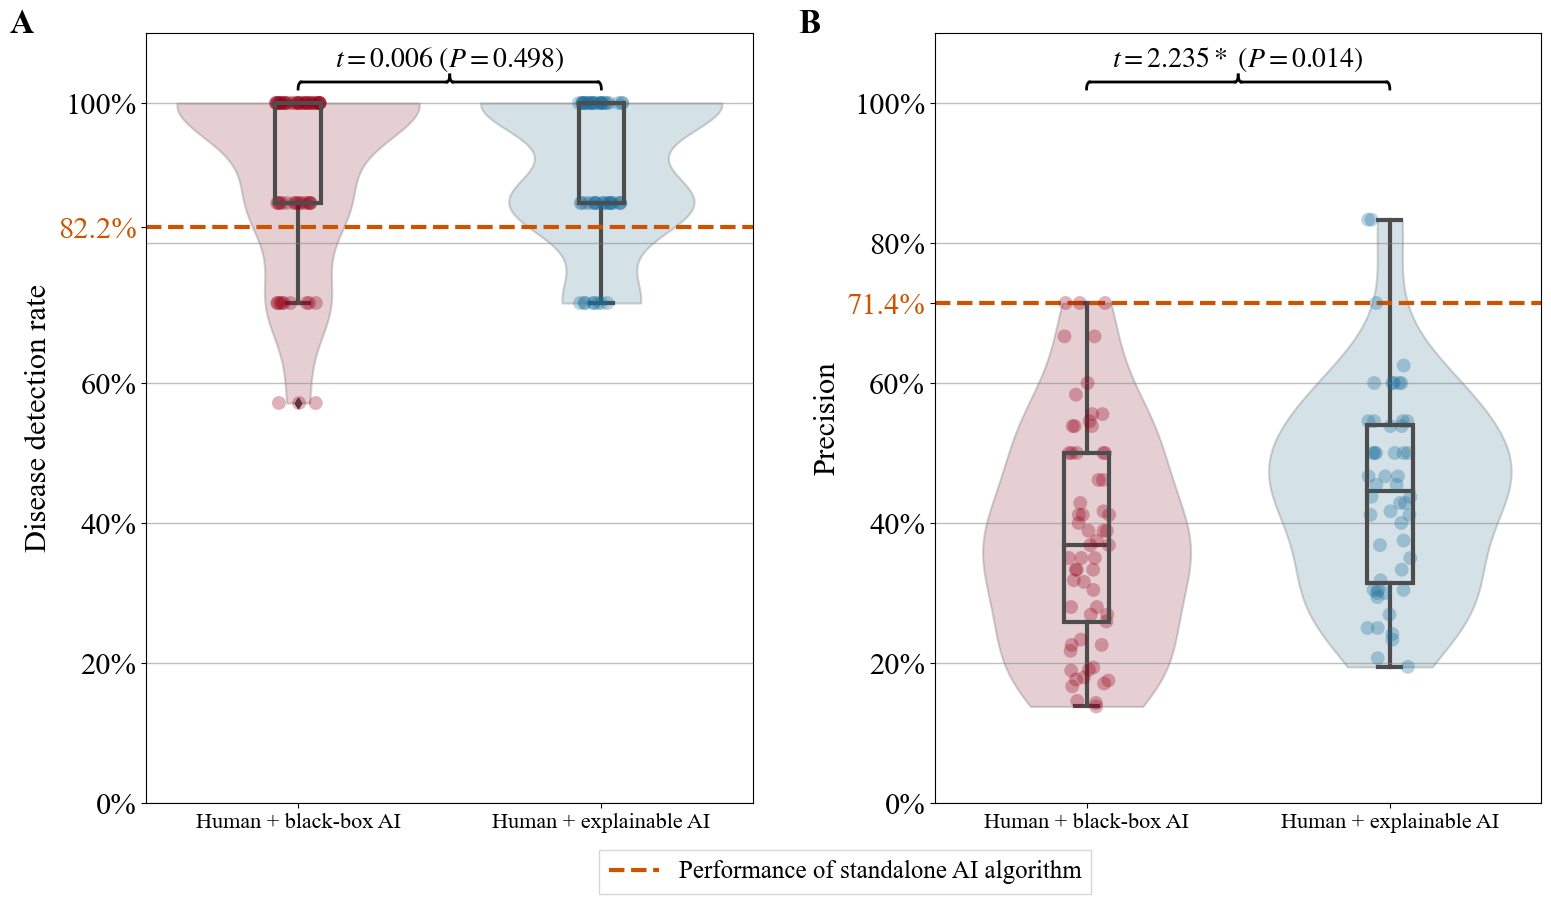

In [36]:
# Plot disease detection rate and precision for all participants
# Calculate t-statistic and p-value
plt.figure(figsize=(18, 10))
plt.subplots_adjust(wspace=0.3)
for metric in ['defect_detection_rate', 'precision']:
    if metric == 'defect_detection_rate':
        ai_metric = ai_bacc
        plot_id = 1
        label = 'Disease detection rate'
        legend = 'Performance of standalone AI algorithm'
    elif metric == 'precision':
        ai_metric = ai_ddr
        plot_id = 2
        label = 'Precision'
        legend = None
    else:
        raise ValueError('Unknown metric', metric)
    plt.subplot(1, 2, plot_id)
    t_stat = stats.ttest_ind(data[metric][data["treatment"]=="a"], data[metric][data["treatment"]=="b"], equal_var = False)[0]
    p_val = stats.ttest_ind(data[metric][data["treatment"]=="a"], data[metric][data["treatment"]=="b"], equal_var = False)[1]/2
    if p_val < 0.001:
        ast = '***'
    elif p_val < 0.01:
        ast = '**'
    elif p_val < 0.05:
        ast = '*'
    else:
        ast = ' '
    print("t-stat: " + str(round(t_stat,3))+ ", P-val: " + str(round(p_val,4)))
    #fig = plt.figure()
    ax = sns.violinplot(x="treatment", y=metric, data=data, inner=None, palette=[red, blue], alpha=0.4, cut=0, order=["a", "b"])
    for art in ax.collections:
        art.set_alpha(0.2)
    ax1 = sns.boxplot(x="treatment", y=metric, data=data, orient="v", width=0.15, color="grey", linewidth=3, boxprops={'facecolor':'none', "zorder":10}, order=["a", "b"])
    ax1 = sns.stripplot(x="treatment", y=metric, data=data, palette=[red, blue], size=10, jitter=0.075, order=["a", "b"], alpha=0.3)
    #plt.scatter(0, data[data['treatment'] == 'a']['balanced_accuracy'].mean(), marker='s', color='black', s=50, alpha=0.6)
    #plt.scatter(1, data[data['treatment'] == 'b']['balanced_accuracy'].mean(), marker='s', color='black', s=50, alpha=0.6, label='Mean')
    plt.hlines(ai_metric, -0.5, 1.5, linestyles='--', color=orange, linewidth=3, alpha=1, label=legend)
    if metric == 'balanced_accuracy':
        plt.hlines(0.5, -0.5, 1.5, linestyles='dotted', color='black', linewidth=3, alpha=1)
    for i in np.arange(0.0, 1.09, 0.2):
        plt.hlines(i, -0.5, 1.5, color='grey', linewidth=1, alpha=0.5)
    plt.xticks([0, 1], ["Human + black-box AI", "Human + explainable AI"], fontsize=16)
    if metric == 'defect_detection_rate':
        plt.yticks([0, 0.2, 0.4, 0.6, 1, ai_metric], labels=['0%', '20%', '40%', '60%', '100%', f'{np.round(ai_metric*100, 1)}%'])
    else:
        plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1, ai_metric], labels=['0%', '20%', '40%', '60%', '80%', '100%', f'{np.round(ai_metric*100, 1)}%'])
    plt.xlabel(None)
    plt.ylabel(label)
    plt.xlim(-0.5, 1.5)
    plt.ylim(0, 1.1)
    #plt.title(label)
    ax.get_yticklabels()[-1].set_color((0.8,0.33,0))
    brace_y_offset = data[metric].max() + 0.01
    curlyBrace(fig, ax, [0, 1.02], [1, 1.02], 0.01, bool_auto=False, str_text=f'$t={np.round(np.abs(t_stat),3)}{ast} \, \, (P={np.round(p_val, 3)})$', color='black', lw=2, int_line_num=1, fontdict=font)
    #if plot_id == 1:
    #    plt.legend(loc=(0.4, -0.15))
    if metric == 'defect_detection_rate':
        plt.text(-0.95, 1.1, 'A', weight='bold', fontsize=24)
    else:
        plt.text(-0.95, 1.1, 'B', weight='bold', fontsize=24)
plt.figlegend(loc=(0.386, 0.015), fancybox=False, fontsize=18)
#plt.tight_layout()
plt.savefig('results_combined_study3_supp.pdf', bbox_inches='tight')

In [37]:
# Print mean precision for treatment arms
print(round(data["precision"][data["treatment"]=="a"].mean()*100,1))
print(round(data["precision"][data["treatment"]=="b"].mean()*100,1))

38.1
44.5


In [38]:
# Print median disease detection rate for treatment arms
print(round(data["precision"][data["treatment"]=="a"].median()*100,1))
print(round(data["precision"][data["treatment"]=="b"].median()*100,1))

36.8
44.6


In [39]:
# OLS regression model without control variables
X = data.loc[:,["treatment"]]
X = X[X["treatment"] != "c"]
X["treatment"] = np.where(X["treatment"] == "a", 0, 1)
X = sm.add_constant(X)
X = X.astype(float)
y = data.loc[:, "precision"].astype(float)*100
y = y.loc[X.index]
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              precision   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     4.929
Date:                Tue, 16 Apr 2024   Prob (F-statistic):             0.0284
Time:                        15:08:22   Log-Likelihood:                -467.81
No. Observations:                 113   AIC:                             939.6
Df Residuals:                     111   BIC:                             945.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         38.0822      1.963     19.401      0.0

In [40]:
# One-sided Welch's t-test for precision ("human + black-box AI" vs. "human + explainable AI")
t_stat = stats.ttest_ind(data["precision"][data["treatment"]=="a"], data["precision"][data["treatment"]=="b"], equal_var = False)[0]
p_val = stats.ttest_ind(data["precision"][data["treatment"]=="a"], data["precision"][data["treatment"]=="b"], equal_var = False)[1]/2
print("t-stat: " + str(round(t_stat,3))+ ", P-val: " + str(round(p_val,4)))

t-stat: -2.235, P-val: 0.0137


## Supplement H: Randomization checks

In [41]:
# Print mean and standard deviation for tenure
print("tenure (mean in a): " + str(round(data["tenure"][data["treatment"]=="a"].mean(),2)))
print("tenure (std in a): " + str(round(data["tenure"][data["treatment"]=="a"].std(),2)))
print("tenure (mean in b): " + str(round(data["tenure"][data["treatment"]=="b"].mean(),2)))
print("tenure (std in b): " + str(round(data["tenure"][data["treatment"]=="b"].std(),2)))

tenure (mean in a): 11.89
tenure (std in a): 8.96
tenure (mean in b): 15.4
tenure (std in b): 11.71


In [42]:
data['treatment'].value_counts()

a    61
b    52
Name: treatment, dtype: int64

In [43]:
# Print P-values for randomization checks
print("tenure (P-value): " + str(round(stats.ttest_ind(data["tenure"][data["treatment"]=="a"], data["tenure"][data["treatment"]=="b"], equal_var=False)[1],3)))

tenure (P-value): 0.08


## Supplement I: Regression models

In [44]:
# OLS regression model (1) for balanced accuracy
X = data.loc[:,["treatment", "tenure"]]
X["treatment"] = np.where(X["treatment"] == "a", 0, 1)
X = sm.add_constant(X)
X = X.astype(float)
y = data.loc[:, "balanced_accuracy"].astype(float)*100
y = y.loc[X.index]
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      balanced_accuracy   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     3.387
Date:                Tue, 16 Apr 2024   Prob (F-statistic):             0.0374
Time:                        15:08:22   Log-Likelihood:                -414.13
No. Observations:                 113   AIC:                             834.3
Df Residuals:                     110   BIC:                             842.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         78.8830      1.612     48.925      0.0

In [45]:
results.pvalues['treatment']

0.012874900336381074

In [46]:
# Quasi-binomial regression model (1) for balanced accuracy
model = sm.GLM(y/100, X, family=sm.families.Binomial())
results = model.fit(scale="X2")
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:      balanced_accuracy   No. Observations:                  113
Model:                            GLM   Df Residuals:                      110
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                        0.058243
Method:                          IRLS   Log-Likelihood:                -38.556
Date:                Tue, 16 Apr 2024   Deviance:                       6.1202
Time:                        15:08:22   Pearson chi2:                     6.41
No. Iterations:                     6   Pseudo R-squ. (CS):           0.003627
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3165      0.102     12.864      0.0

In [47]:
results.pvalues['treatment']

0.010343511724261152

In [48]:
# OLS regression model (1) for disease detection rate
X = data.loc[:,["treatment", "tenure"]]
X["treatment"] = np.where(X["treatment"] == "a", 0, 1)
X = sm.add_constant(X)
X = X.astype(float)
y = data.loc[:, "defect_detection_rate"].astype(float)*100
y = y.loc[X.index]
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                              OLS Regression Results                             
Dep. Variable:     defect_detection_rate   R-squared:                       0.001
Model:                               OLS   Adj. R-squared:                 -0.017
Method:                    Least Squares   F-statistic:                   0.06830
Date:                   Tue, 16 Apr 2024   Prob (F-statistic):              0.934
Time:                           15:08:22   Log-Likelihood:                -439.01
No. Observations:                    113   AIC:                             884.0
Df Residuals:                        110   BIC:                             892.2
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         90.8803 

In [49]:
results.pvalues['treatment']

0.9550117250564162

In [50]:
# Quasi-binomial regression model (1) for disease detection rate
model = sm.GLM(y/100, X, family=sm.families.Binomial())
results = model.fit(scale="X2")
print(results.summary())

                   Generalized Linear Model Regression Results                   
Dep. Variable:     defect_detection_rate   No. Observations:                  113
Model:                               GLM   Df Residuals:                      110
Model Family:                   Binomial   Df Model:                            2
Link Function:                     Logit   Scale:                         0.16468
Method:                             IRLS   Log-Likelihood:                -27.686
Date:                   Tue, 16 Apr 2024   Deviance:                       19.975
Time:                           15:08:22   Pearson chi2:                     18.1
No. Iterations:                        7   Pseudo R-squ. (CS):          0.0001952
Covariance Type:               nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2972 

In [51]:
results.pvalues['treatment']

0.9547450256523234

In [52]:
# OLS regression model (2) for balanced accuracy
X = data.loc[:,["treatment", "tenure", "it_skills"]]
X["treatment"] = np.where(X["treatment"] == "a", 0, 1)
X = sm.add_constant(X)
X = X.astype(float)
y = data.loc[:, "balanced_accuracy"].astype(float)*100
y = y.loc[X.index]
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      balanced_accuracy   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     2.448
Date:                Tue, 16 Apr 2024   Prob (F-statistic):             0.0676
Time:                        15:08:22   Log-Likelihood:                -413.82
No. Observations:                 113   AIC:                             835.6
Df Residuals:                     109   BIC:                             846.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         76.3317      3.682     20.733      0.0

In [53]:
results.pvalues['treatment']

0.01795291666820565

In [54]:
# Quasi-binomial regression model (2) for balanced accuracy
model = sm.GLM(y/100, X, family=sm.families.Binomial())
results = model.fit(scale="X2")
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:      balanced_accuracy   No. Observations:                  113
Model:                            GLM   Df Residuals:                      109
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                        0.058527
Method:                          IRLS   Log-Likelihood:                -38.538
Date:                Tue, 16 Apr 2024   Deviance:                       6.0845
Time:                        15:08:22   Pearson chi2:                     6.38
No. Iterations:                     6   Pseudo R-squ. (CS):           0.003941
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1512      0.234      4.916      0.0

In [55]:
results.pvalues['treatment']

0.01472070163522477

In [56]:
# OLS regression model (2) for disease detection rate
X = data.loc[:,["treatment", "tenure", "it_skills"]]
X["treatment"] = np.where(X["treatment"] == "a", 0, 1)
X = sm.add_constant(X)
X = X.astype(float)
y = data.loc[:, "defect_detection_rate"].astype(float)*100
y = y.loc[X.index]
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                              OLS Regression Results                             
Dep. Variable:     defect_detection_rate   R-squared:                       0.004
Model:                               OLS   Adj. R-squared:                 -0.023
Method:                    Least Squares   F-statistic:                    0.1595
Date:                   Tue, 16 Apr 2024   Prob (F-statistic):              0.923
Time:                           15:08:22   Log-Likelihood:                -438.83
No. Observations:                    113   AIC:                             885.7
Df Residuals:                        109   BIC:                             896.6
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         93.2966 

In [57]:
results.pvalues['treatment']

0.8955703731205901

In [58]:
# Quasi-binomial regression model (2) for disease detection rate
model = sm.GLM(y/100, X, family=sm.families.Binomial())
results = model.fit(scale="X2")
print(results.summary())

                   Generalized Linear Model Regression Results                   
Dep. Variable:     defect_detection_rate   No. Observations:                  113
Model:                               GLM   Df Residuals:                      109
Model Family:                   Binomial   Df Model:                            3
Link Function:                     Logit   Scale:                         0.16652
Method:                             IRLS   Log-Likelihood:                -27.657
Date:                   Tue, 16 Apr 2024   Deviance:                       19.917
Time:                           15:08:22   Pearson chi2:                     18.2
No. Iterations:                        7   Pseudo R-squ. (CS):          0.0007042
Covariance Type:               nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5841 

In [59]:
results.pvalues['treatment']

0.8950002022698054

In [60]:
# OLS regression model (3) for balanced accuracy
X = data.loc[:,["treatment", "tenure", "it_skills", "median_decision_speed"]]
X["treatment"] = np.where(X["treatment"] == "a", 0, 1)
X = sm.add_constant(X)
X = X.astype(float)
y = data.loc[:, "balanced_accuracy"].astype(float)*100
y = y.loc[X.index]
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      balanced_accuracy   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     1.833
Date:                Tue, 16 Apr 2024   Prob (F-statistic):              0.128
Time:                        15:08:22   Log-Likelihood:                -413.79
No. Observations:                 113   AIC:                             837.6
Df Residuals:                     108   BIC:                             851.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    75.82

In [61]:
results.pvalues['treatment']

0.0180740334556274

In [62]:
# Quasi-binomial regression model (3) for balanced accuracy
model = sm.GLM(y/100, X, family=sm.families.Binomial())
results = model.fit(scale="X2")
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:      balanced_accuracy   No. Observations:                  113
Model:                            GLM   Df Residuals:                      108
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                        0.058906
Method:                          IRLS   Log-Likelihood:                -38.537
Date:                Tue, 16 Apr 2024   Deviance:                       6.0813
Time:                        15:08:22   Pearson chi2:                     6.36
No. Iterations:                     6   Pseudo R-squ. (CS):           0.003970
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.11

In [63]:
results.pvalues['treatment']

0.01471423897795016

In [64]:
# OLS regression model (3) for disease detection rate
X = data.loc[:,["treatment", "tenure", "it_skills", "median_decision_speed"]]
X["treatment"] = np.where(X["treatment"] == "a", 0, 1)
X = sm.add_constant(X)
X = X.astype(float)
y = data.loc[:, "defect_detection_rate"].astype(float)*100
y = y.loc[X.index]
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                              OLS Regression Results                             
Dep. Variable:     defect_detection_rate   R-squared:                       0.096
Model:                               OLS   Adj. R-squared:                  0.063
Method:                    Least Squares   F-statistic:                     2.872
Date:                   Tue, 16 Apr 2024   Prob (F-statistic):             0.0264
Time:                           15:08:22   Log-Likelihood:                -433.37
No. Observations:                    113   AIC:                             876.7
Df Residuals:                        108   BIC:                             890.4
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------


In [65]:
results.pvalues['treatment']

0.769835122551237

In [66]:
# Quasi-binomial regression model (3) for disease detection rate
model = sm.GLM(y/100, X, family=sm.families.Binomial())
results = model.fit(scale="X2")
print(results.summary())

                   Generalized Linear Model Regression Results                   
Dep. Variable:     defect_detection_rate   No. Observations:                  113
Model:                               GLM   Df Residuals:                      108
Model Family:                   Binomial   Df Model:                            4
Link Function:                     Logit   Scale:                         0.15366
Method:                             IRLS   Log-Likelihood:                -26.706
Date:                   Tue, 16 Apr 2024   Deviance:                       18.016
Time:                           15:08:22   Pearson chi2:                     16.6
No. Iterations:                        8   Pseudo R-squ. (CS):            0.01738
Covariance Type:               nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------


In [67]:
results.pvalues['treatment']

0.7777318933596453

## Supplement J: Analysis with excluded participants

#### Get numbers of excluded participants per treatment arm

In [68]:
# Import study data (excluding dropouts)
data = pd.read_csv("data_study_03.csv")
# Rename treatment arms to "a" and "b"
data["treatment"][data["treatment"] == "human_with_black-box_AI"] = "a"
data["treatment"][data["treatment"] == "human_with_explainable_AI"] = "b"

In [69]:
data[data["completed_images"] != 50]["treatment"].value_counts()

b    2
Name: treatment, dtype: int64

In [70]:
data = data[data["completed_images"] == 50].copy()

In [71]:
data[data["only_one_answer"] == 1]["treatment"].value_counts()

a    1
Name: treatment, dtype: int64

In [72]:
data = data[data["only_one_answer"] == 0].copy()

In [73]:
data["treatment"].value_counts()

a    62
b    53
Name: treatment, dtype: int64

In [74]:
# Remove participants whose performance was more than three standard deviations worse than the mean of their respective treatment arm
cutoff_a = data["balanced_accuracy"][data["treatment"] == "a"].mean() - 3 * data["balanced_accuracy"][
    data["treatment"] == "a"].std()
cutoff_b = data["balanced_accuracy"][data["treatment"] == "b"].mean() - 3 * data["balanced_accuracy"][
    data["treatment"] == "b"].std()
data = data[~((data["treatment"] == "a") & (data["balanced_accuracy"] < cutoff_a))]
data = data[~((data["treatment"] == "b") & (data["balanced_accuracy"] < cutoff_b))]

In [75]:
data["treatment"].value_counts()

a    61
b    52
Name: treatment, dtype: int64

#### Perform OLS with all combinations of exclusion criteria

In [76]:
from itertools import combinations

In [77]:
# Import study data (excluding dropouts)
data = pd.read_csv("data_study_03.csv")

In [78]:
# Rename treatment arms to "a" and "b"
data["treatment"][data["treatment"]=="human_with_black-box_AI"] = "a"
data["treatment"][data["treatment"]=="human_with_explainable_AI"] = "b"

In [79]:
data["time-out"] = data["completed_images"] != 50

In [80]:
data["single_label"] = data["only_one_answer"] == 1

In [81]:
data["worse_3sds"] = ((data["treatment"] == "a") & (data["balanced_accuracy"] < cutoff_a)) | ((data["treatment"] == "b") & (data["balanced_accuracy"] < cutoff_b))

In [82]:
excl_criteria = ['time-out', 'single_label', 'worse_3sds']

In [83]:
# Impute missing data for tenure and it_skills with median values
data["tenure"] = data["tenure"].fillna(data["tenure"].median())
data["it_skills"] = data["it_skills"].fillna(data["it_skills"].median())

In [84]:
list_combinations = list()

for n in range(len(excl_criteria)):
    list_combinations += list(combinations(excl_criteria, n))

In [85]:
covariates1 = ["treatment", "tenure"]
covariates2 = ["treatment", "tenure", "it_skills"]
covariates3 = ["treatment", "tenure", "it_skills", "median_decision_speed"]

In [86]:
results_df = pd.DataFrame(data=None, columns=[str(i) for i in range(1, 8)])
for metric in ["balanced_accuracy", "defect_detection_rate"]:
    for model_id, covariates in enumerate([covariates1, covariates2, covariates3]):
        results_df.loc["Observations", :] = np.nan
        results_df.loc[metric+"_"+str(int(model_id+1))+"_coef", :] = np.nan
        results_df.loc[metric+"_"+str(int(model_id+1))+"_se", :] = np.nan
for metric in ["balanced_accuracy", "defect_detection_rate"]:
    for sample_id, combination in enumerate(list_combinations):
        data_sub = data.copy()
        for criterion in combination:
            data_sub = data_sub[~data_sub[criterion]].copy()
        results_df.loc['Observations', str(int(sample_id+1))] = len(data_sub)
        for model_id, covariates in enumerate([covariates1, covariates2, covariates3]):
            #print("Model:", model_id+1)
            X = data_sub.loc[:, covariates]
            X["treatment"] = np.where(X["treatment"] == "a", 0, 1)
            X = sm.add_constant(X)
            X = X.astype(float)
            y = data_sub.loc[:, metric].astype(float)*100
            y = y.loc[X.index]
            model = sm.OLS(y, X)
            results = model.fit()
            #print("Coef:", np.round(results.params["treatment"], 3), "se:", np.round(results.bse["treatment"], 3), "p:", np.round(results.pvalues["treatment"], 5))
            if results.pvalues["treatment"] < 0.001:
                ast = "***"
            elif results.pvalues["treatment"] < 0.01:
                ast = "**"
            elif results.pvalues["treatment"] < 0.05:
                ast = "*"
            else:
                ast = ""
            results_df.loc[metric+"_"+str(int(model_id+1))+"_coef", str(int(sample_id+1))] = "{:.3f}".format(np.round(results.params["treatment"], 3))+ast
            results_df.loc[metric+"_"+str(int(model_id+1))+"_se", str(int(sample_id+1))] = "({:.3f})".format(np.round(results.bse["treatment"], 3))

In [87]:
# Formatter function to apply tiny font size
def tiny_font(x):
    return r'\tiny{' + str(x) + '}'

# Apply formatter to each column
formatters = {col: tiny_font for col in results_df.columns}

# Generate LaTeX code
latex_output = results_df.to_latex(formatters=formatters, escape=False, index=False)
print(latex_output)

\begin{tabular}{lllllll}
\toprule
             1 &              2 &              3 &              4 &              5 &              6 &              7 \\
\midrule
    \tiny{118} &     \tiny{116} &     \tiny{117} &     \tiny{115} &     \tiny{115} &     \tiny{114} &     \tiny{114} \\
 \tiny{4.222*} &  \tiny{5.124*} &   \tiny{3.769} &  \tiny{4.921*} &  \tiny{4.671*} & \tiny{5.107**} &  \tiny{4.451*} \\
\tiny{(2.098)} & \tiny{(2.031)} & \tiny{(2.056)} & \tiny{(1.880)} & \tiny{(1.984)} & \tiny{(1.893)} & \tiny{(1.822)} \\
 \tiny{4.355*} &  \tiny{5.235*} &   \tiny{3.818} &  \tiny{4.852*} &  \tiny{4.698*} & \tiny{5.035**} &  \tiny{4.268*} \\
\tiny{(2.121)} & \tiny{(2.052)} & \tiny{(2.084)} & \tiny{(1.901)} & \tiny{(2.010)} & \tiny{(1.913)} & \tiny{(1.842)} \\
 \tiny{4.357*} &  \tiny{5.272*} &   \tiny{3.821} &  \tiny{4.860*} &  \tiny{4.730*} & \tiny{5.069**} &  \tiny{4.269*} \\
\tiny{(2.130)} & \tiny{(2.059)} & \tiny{(2.094)} & \tiny{(1.910)} & \tiny{(2.018)} & \tiny{(1.922)} & \tiny{(1.851)} 